<a href="https://colab.research.google.com/github/wxya2017/GR5242-CIFAR10/blob/master/keras_model_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
# 指定当前的工作目录

In [0]:
import os
os.chdir("drive/5242") 

In [4]:
import cv2
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
# from tensorflow.python.eager import context

import keras
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
# from tensorflow.train import AdamOptimizer
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras import regularizers, optimizers
# from tensorflow.keras.callbacks import TensorBoard
# from tensorflow.keras import regularizers, optimizers
import time

from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import regularizers, optimizers
from keras.callbacks import TensorBoard
from keras import regularizers, optimizers


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [0]:
import os
import tensorflow as tf
from keras.callbacks import TensorBoard

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [0]:
# Run Tensorflow in the background - note that we specify the log 
# directory we want to look at
LOG_DIR = 'logs_keras_new'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [10]:
# Launch the ngrok background process
get_ipython().system_raw('./ngrok http 6006 &')

# Get the public URL and be sorted!
! curl -s http://localhost:4040/api/tunnels | python3 -c\
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://2e4a58c9.ngrok.io


In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def load_data(dir):
    train_x = np.array(unpickle(dir+'data_batch_1')[b'data'])
    train_y = np.array(unpickle(dir+'data_batch_1')[b'labels'])
    for i in range(2,6):
        train_x = np.concatenate((train_x, np.array(unpickle(dir+'data_batch_'+str(i))[b'data'])), axis = 0)
        train_y = np.concatenate((train_y, np.array(unpickle(dir+'data_batch_'+str(i))[b'labels'])),axis = 0)


    test_x = np.array(unpickle(dir+'test_batch')[b'data'])
    test_y = np.array(unpickle(dir+'test_batch')[b'labels'])   
    labels = unpickle(dir+'batches.meta')[b'label_names']
    return train_x, train_y, test_x, test_y, labels

In [0]:
def reshape(image):
    out = np.zeros(shape=[32,32,3])
    for i in range(3):
        out[:,:,i] = image[1024*i:1024*(i+1)].reshape([32,32])
    return out

def pre_process_x(x):
    new_x = np.zeros(shape=[len(x),32,32,3])
    for i in range(len(x)):
        new_x[i] = reshape(x[i])
    new_x = new_x/255
    return new_x

def pre_process_y(y):
    new_y = np.zeros([len(y),10])
    for i in range(len(y)):
        new_y[i][y[i]-1] = 1
    return new_y

In [0]:
# Functions for plots
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2,figsize=(10, 5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'validation'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'validation'], loc='best')
    plt.show()

In [14]:
ori_train_x, ori_train_y, ori_test_x, ori_test_y, labels = load_data('data/')

train_x = pre_process_x(ori_train_x)
test_x = pre_process_x(ori_test_x)
train_y = pre_process_y(ori_train_y)
test_y = pre_process_y(ori_test_y)
print("===>training data shape is "+ str(train_x.shape))
print("===>test data shape is "+ str(test_x.shape))
print("===>training label shape is "+ str(train_y.shape))
print("===>test label shape is "+ str(test_y.shape))

===>training data shape is (50000, 32, 32, 3)
===>test data shape is (10000, 32, 32, 3)
===>training label shape is (50000, 10)
===>test label shape is (10000, 10)


In [0]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# baseline

In [0]:
def build_model_base(num_classes = 10, baseMapNum = 32):
    '''build weight decay model'''
    model_base = Sequential()
    model_base.add(Conv2D(baseMapNum, (3,3), name='conv1', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=train_x.shape[1:]))
    model_base.add(Activation('relu', name='relu1'))
    
    model_base.add(Conv2D(baseMapNum, (3,3), name='conv2', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu2'))
    model_base.add(MaxPooling2D(pool_size=(2,2), name='maxp1'))
    model_base.add(Dropout(0.5, name='drop1'))
    
    model_base.add(Conv2D(2*baseMapNum, (3,3), name='conv3', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu3'))
    
    model_base.add(Conv2D(2*baseMapNum, (3,3), name='conv4', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model_base.add(Activation('relu', name='relu4'))
    model_base.add(MaxPooling2D(pool_size=(2,2), name='maxp2'))
    model_base.add(Dropout(0.3, name='drop2'))


    model_base.add(Flatten())
    model_base.add(Dense(num_classes, activation='softmax', name='dense'))
    
    model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    return model_base


In [12]:
model_base = build_model_base()
print(model_base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
relu2 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
maxp1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        18496     
__________

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras_new/model_baseline_ep250', write_graph=True)
datagen.fit(train_x)
#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
fit_history_base = model_base.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                            steps_per_epoch=iterations,
                                            epochs=epochs,
                                            verbose=1,
                                            validation_data=(valid_x,valid_y),
                                            callbacks=[tbCallBack])
                    
model_base.save('model/model_baseline_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

In [15]:
# plot_model_history(fit_history1)
baseline_evalu = model_base.evaluate(test_x, test_y, batch_size=128, verbose=1)
acc = baseline_evalu[1]; loss = baseline_evalu[0]
print('\nTest result: %.3f loss: %.3f' % (acc*100, loss))

# model_decay_test = load_model('model/model_weight_decay_test.h5')

10000/10000 [==============================] - 1s 90us/step

Test result: 77.340 loss: 0.820


Text(69,0.5,'Predicted label')

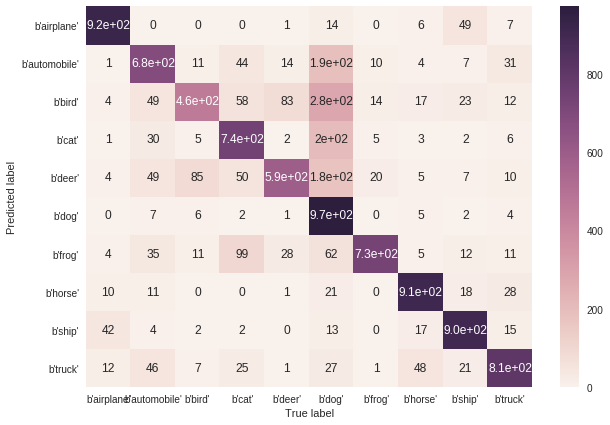

In [20]:
y_prob_base = model_base.predict(test_x) 
y_pred_base = y_prob_base.argmax(axis=-1)
y_true = np.where(test_y == 1)[1]
cm = confusion_matrix(y_true, y_pred_base, labels = range(10))
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')

# more layers: weight decay l2, batchnormalization

In [0]:
def build_model_batchnorm(num_classes = 10, baseMapNum = 32, weight_decay = 1e-4):
    '''build weight decay model'''
    model_decay = Sequential()
    model_decay.add(Conv2D(baseMapNum, (3,3), name='conv1', padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_x.shape[1:]))
    model_decay.add(Activation('relu', name='relu1'))
    model_decay.add(BatchNormalization(name='batchn1'))
    model_decay.add(Conv2D(baseMapNum, (3,3), name='conv2', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model_decay.add(Activation('relu', name='relu2'))
    model_decay.add(BatchNormalization(name='batchn2'))
    model_decay.add(MaxPooling2D(pool_size=(2,2), name='maxp1'))
    model_decay.add(Dropout(0.2, name='drop1'))

    model_decay.add(Conv2D(2*baseMapNum, (3,3), name='conv3', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model_decay.add(Activation('relu', name='relu3'))
    model_decay.add(BatchNormalization(name='batchn3'))
    model_decay.add(Conv2D(2*baseMapNum, (3,3), name='conv4', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model_decay.add(Activation('relu', name='relu4'))
    model_decay.add(BatchNormalization(name='batchn4'))
    model_decay.add(MaxPooling2D(pool_size=(2,2), name='maxp2'))
    model_decay.add(Dropout(0.3, name='drop2'))

    model_decay.add(Conv2D(4*baseMapNum, (3,3), name='conv5', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model_decay.add(Activation('relu', name='relu5'))
    model_decay.add(BatchNormalization(name='batchn5'))
    model_decay.add(Conv2D(4*baseMapNum, (3,3), name='conv6', padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model_decay.add(Activation('relu', name='relu6'))
    model_decay.add(BatchNormalization(name='batchn6'))
    model_decay.add(MaxPooling2D(pool_size=(2,2), name='maxp3'))
    model_decay.add(Dropout(0.4, name='drop3'))

    model_decay.add(Flatten(name='flat1'))
    model_decay.add(Dense(num_classes, activation='softmax', name='dense1'))
    
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model_decay.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    
    return model_decay


In [17]:
model_batchnorm = build_model_batchnorm()
print(model_batchnorm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
batchn1 (BatchNormalization) (None, 32, 32, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
relu2 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
batchn2 (BatchNormalization) (None, 32, 32, 32)        128       
_________________________________________________________________
maxp1 (MaxPooling2D)         (None, 16, 16, 32)        0         
__________

150 epochs

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras_new/model_batchnorm_ep150',write_graph=True)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=150
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_batchnorm150 = model_batchnorm.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                         steps_per_epoch=iterations,
                                         epochs=epochs,
                                         verbose=1,
                                         validation_data=(valid_x,valid_y),
                                         callbacks=[tbCallBack])
model_batchnorm.save('model/model_batchnorm_ep150.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))


In [21]:
# plot_model_history(fit_history1)
batchnorm_evalu = model_batchnorm.evaluate(test_x, test_y, batch_size=128, verbose=1)
acc = batchnorm_evalu[1]; loss = batchnorm_evalu[0]
print('\nTest result: %.3f loss: %.3f' % (acc*100, loss))

# model_decay_test = load_model('model/model_weight_decay_test.h5')

10000/10000 [==============================] - 2s 192us/step

Test result: 79.780 loss: 0.815


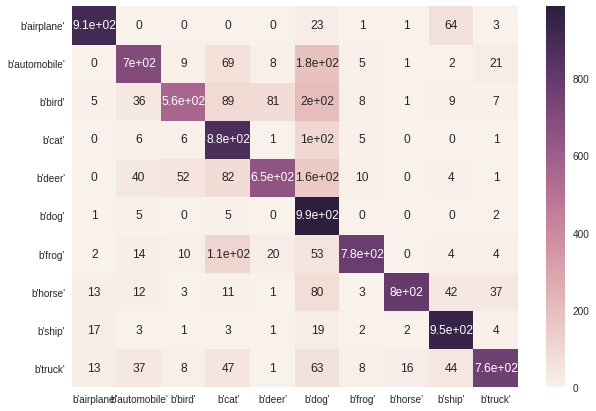

In [23]:
y_prob = model_batchnorm.predict(test_x) 
y_pred = y_prob.argmax(axis=-1)
y_true = np.where(test_y == 1)[1]
cm = confusion_matrix(y_true, y_pred, labels = range(10))
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

250 epochs

In [0]:
model_batchnorm = build_model_batchnorm()

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras_new/model_batchnorm_ep250',write_graph=True)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_batchnorm_250 = model_batchnorm.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                         steps_per_epoch=iterations,
                                         epochs=epochs,
                                         verbose=1,
                                         validation_data=(valid_x,valid_y),
                                         callbacks=[tbCallBack])
model_batchnorm.save('model/model_batchnorm_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))

# NIN

In [0]:
def build_model_NIN(train_x, num_classes = 10, baseMapNum = 32, weight_decay = 1e-4):
    '''build NIN model: 
       1.convolution layer followed by 2 1*1 convlution layer(mlp)
       2.end with 10 filters mlp, averagepooling, softmax
    '''
    model= Sequential()
    model.add(Conv2D(baseMapNum*3, (5,5), name='conv1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001), input_shape=train_x.shape[1:]))
    model.add(Activation('relu', name='relu1'))
    model.add(Conv2D(baseMapNum*2, (1,1), name='mlp1', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu2'))
    model.add(Conv2D(baseMapNum*2, (1,1), name='mlp2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu3'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxp1'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(baseMapNum*3, (3,3), name='conv2', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu4'))
    model.add(Conv2D(baseMapNum*2, (1,1), name='mlp3', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu5'))
    model.add(Conv2D(baseMapNum*2, (1,1), name='mlp4', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu6'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxp2'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(baseMapNum*2, (3,3), name='conv3', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu7'))
    model.add(Conv2D(baseMapNum, (1,1), name='mlp5', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu8'))
    model.add(Conv2D(num_classes, (1,1), name='mlp6', padding = 'same', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Activation('relu', name='relu9'))
    model.add(AveragePooling2D(pool_size=(2, 2), name='maxp3'))
    
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    
    return model





In [0]:
NIN = build_model_NIN()
print(NIN)

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras_new/model_NIN_ep150',write_graph=True)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=150
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_nin_150 = NIN.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                         steps_per_epoch=iterations,
                                         epochs=epochs,
                                         verbose=1,
                                         validation_data=(valid_x,valid_y),
                                         callbacks=[tbCallBack])
NIN.save('model/model_nin_ep150.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))


In [0]:
NIN = build_model_NIN()

In [0]:
tbCallBack =TrainValTensorBoard(log_dir='logs_keras_new/model_NIN_ep250',write_graph=True)
datagen.fit(train_x)

#training
start = time.time()

batch_size = 128
epochs=250
iterations = int(train_x.shape[0]/128)
steps_per_epoch=iterations
fit_history_nin_250 = NIN.fit_generator(datagen.flow(train_x, train_y, batch_size=batch_size),
                                         steps_per_epoch=iterations,
                                         epochs=epochs,
                                         verbose=1,
                                         validation_data=(valid_x,valid_y),
                                         callbacks=[tbCallBack])
NIN.save('model/model_nin_ep250.h5')

end = time.time()
print("Model took %0.2f seconds to train"%(end - start))